In [171]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import psycopg2
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline 

In [230]:

try:
    conn = psycopg2.connect("dbname='crops' user='postgres' host='localhost' port='5433'")
    cur = conn.cursor()
except:
    print "Unable to connect to the database"


In [231]:
%%time
cur.execute("""
SELECT  (
        SELECT COUNT(*)
        FROM   "2009"      ) AS count9,
        (
        SELECT COUNT(*)
        FROM   "2010"       ) AS count10,
        
        (
        SELECT COUNT(*)
        FROM   "2011"       ) AS count11,
        
        (
        SELECT COUNT(*)
        FROM   "2012"       ) AS count12,
        (
        SELECT COUNT(*)
        FROM   "2013"       ) AS count13,
        (
        SELECT COUNT(*)
        FROM   "2014"       ) AS count14,
        (
        SELECT COUNT(*)
        FROM   "2015"       ) AS count15,
        (
        SELECT COUNT(*)
        FROM   "2016"       ) AS count16

""")
rows = cur.fetchall()

for row in rows:
    print "   ", row[0]

    819146
CPU times: user 899 µs, sys: 1.12 ms, total: 2.02 ms
Wall time: 3.92 s


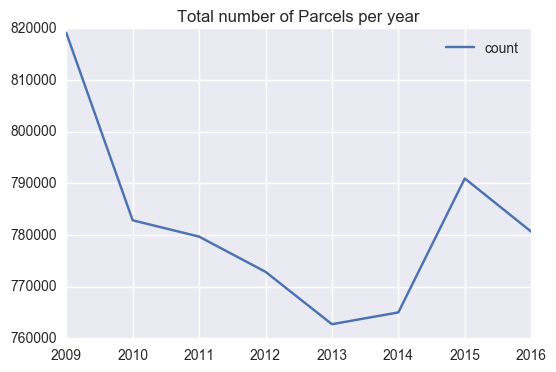

In [232]:
rowCounts = pd.DataFrame(list(rows[0]), index=["2009","2010","2011","2012","2013","2014","2015","2016"],columns=["count"])
rowCounts.plot(title="Total number of Parcels per year", kind='line')

In [165]:
%%time 

refDf = pd.read_sql_query('select global_geo_id, gws_gewas as c2009 from "2009"', conn)


for i in range(2010,2017):
    if i <2015:
        tmp_df =  pd.read_sql_query('select gws_gewas as c'+str(i)+', global_geo_id from "'+str(i)+'"', conn)
    else: #table name for 2015 and 2016 is different 
        tmp_df =  pd.read_sql_query('select gws_gewas as c'+str(i)+', global_geo_id from "bf_'+str(i)+'"', conn)
        
#     print "nulls ", tmp_df["global_geo_id"].isnull().sum()#'c'+str(i)].isnull().sum()
    refDf = refDf.merge(tmp_df,how="left")
#     print "nulls ", refDf['c'+str(i)].isnull().sum()

# df10 = pd.read_sql_query('select gid,gws_gewas, global_geo_id from "2010"', conn)
# df11 = pd.read_sql_query('select gid,gws_gewas, global_geo_id from "2011"', conn)
# df12 = pd.read_sql_query('select gid,gws_gewas, global_geo_id from "2012"', conn)
# df13 = pd.read_sql_query('select gid,gws_gewas, global_geo_id from "2013"', conn)
# df14 = pd.read_sql_query('select gid,gws_gewas, global_geo_id from "2014"', conn)
# df15 = pd.read_sql_query('select gid,gws_gewas, global_geo_id from "bf_2015"', conn)
# df16 = pd.read_sql_query('select gid,gws_gewas, global_geo_id from "bf_2016"', conn)



CPU times: user 6.6 s, sys: 1.71 s, total: 8.3 s
Wall time: 21.3 s


In [166]:
refDf.head()

,global_geo_id,c2009,c2010,c2011,c2012,c2013,c2014,c2015,c2016
0,389835,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-"
1,389836,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-"
2,389837,"Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-"
3,389838,"Grasland, tijdelijk","Grasland, tijdelijk","Grasland, tijdelijk","Grasland, tijdelijk",NaN,NaN,"Maïs, snij-","Uien, poot- en plant- (incl. sjalotten)"
4,389839,"Grasland, tijdelijk","Grasland, tijdelijk","Grasland, tijdelijk","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-","Maïs, snij-"


In [167]:
for i in range(2010,2016):
    print 'nulls in year {}: '.format(i), refDf['c'+str(i)].isnull().sum()
    
    
    

nulls in year 2010:  130436
nulls in year 2011:  166271
nulls in year 2012:  193027
nulls in year 2013:  219926
nulls in year 2014:  240144
nulls in year 2015:  258764


In [234]:
df_noNA = refDf.dropna()
df_noNA = df_noNA.sample(frac=1)
print "dataset size: ", len(df_noNA)
df_noNA.head(10)

# train_size = int(len(df_noNA) * 0.7)
# test_size = len(df_noNA) - train_size
# train, test = df_noNA.iloc[0:train_size], df_noNA.iloc[train_size:len(df_noNA)]



dataset size:  464060


,global_geo_id,c2009,c2010,c2011,c2012,c2013,c2014,c2015,c2016
727997,295645,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend"
326405,715835,Boomkwekerij en vaste planten,Boomkwekerij en vaste planten,Boomkwekerij en vaste planten,Boomkwekerij en vaste planten,"Boomkwekerijgewassen en vaste planten, pot- en...","Boomkwekerijgewassen en vaste planten, pot- en...","Sierheesters en klimplanten, pot- en container...","Sierheesters en klimplanten, pot- en container..."
33586,423433,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend"
561026,128909,"Tarwe, winter-","Bieten, suiker-","Vlas, vezel- (voor zaaizaad)","Aardappelen, consumptie op klei/lössgrond","Tarwe, winter-",Vezelvlas,"Uien, zaai-","Bieten, suiker-"
692094,259735,"Koolzaad, winter (ook boterzaad)","Bieten, suiker-",Bloembollen en - knollen,"Maïs, snij-","Maïs, snij-","Tarwe, zomer-","Narcis, bloembollen en -knollen","Narcis, bloembollen en -knollen"
151612,541329,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend"
817399,384849,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, tijdelijk","Grasland, tijdelijk","Grasland, tijdelijk","Grasland, blijvend","Grasland, tijdelijk"
150062,539776,"Uien, zaai-","Tarwe, winter-","Aardappelrassen, poot- op kleigrond","Tarwe, winter-",Groenten open grond (inclusief groentezaden),"Aardappelen, poot op klei/lössgrond (NAK)","Uien, zaai-","Tarwe, winter-"
365315,754709,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend"
399949,789185,"Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Grasland, blijvend","Maïs, snij-","Maïs, snij-","Maïs, snij-"


So we're working with 56% of the original 2009 db size. 

In [240]:

useless_parcels = ["Braak, natuur-","Grasland, blijvend", "Onbekend/gewas niet opgegeven","Bos (SBL-regeling)",
                  "Natuurlijk grasland met hoofdfunctie landbouw",\
                  "Braak met bos (SBL-regeling na 28 juni 1995)",\
                  "Natuurlijk grasland (begraasd) met beperkte landbouwact.",\
                  "Dummycode voor dummypercelen",\
                  "Overige natuurterreinen",\
                    "Faunaranden"]

for i in range(2009,2017):
    print 'Useless parcels in year {}: '.format(i), refDf['c'+str(i)].isin(useless_parcels).sum()
    
    

Useless parcels in year 2009:  439616
Useless parcels in year 2010:  387474
Useless parcels in year 2011:  375677
Useless parcels in year 2012:  338392
Useless parcels in year 2013:  317487
Useless parcels in year 2014:  304118
Useless parcels in year 2015:  306781
Useless parcels in year 2016:  291317


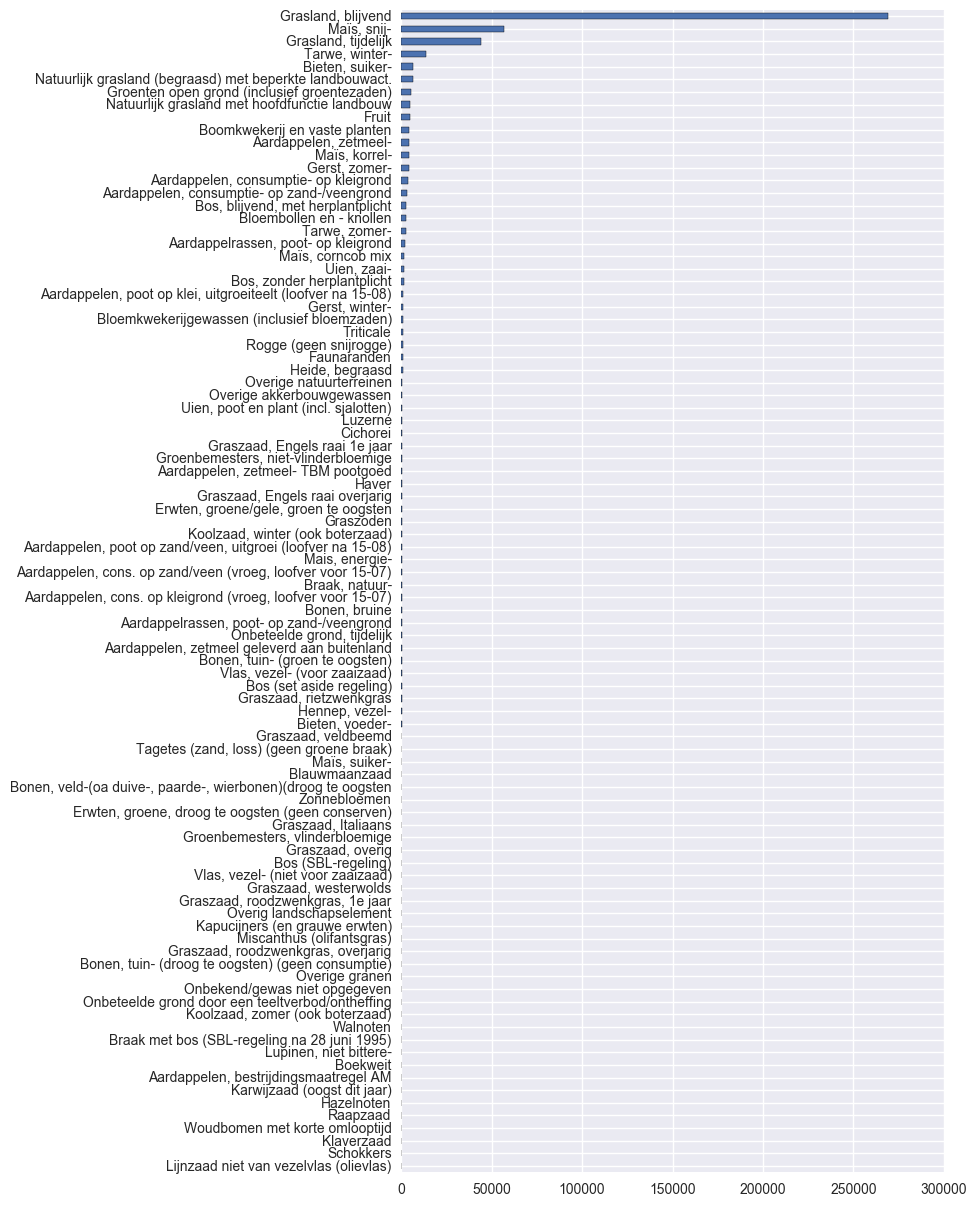

In [243]:
df_noNA.c2010.value_counts().sort_values().plot(kind='barh',figsize=(7, 15))


In [242]:
#clean unused parcels
cleaned_df = df_noNA.copy()


for i in range(2009,2017):
    cleaned_df = cleaned_df[~cleaned_df['c'+str(i)].isin(useless_parcels)]
 

len(cleaned_df)

135741

#### Model Training

In [244]:
# change categorical variables for model training
# for now we're interested in potatos, so if crop type contains the word Aardappelen we'll set it to 1, otherwise to 0

cleaned_df.ix[:,1:]= cleaned_df.ix[:,1:].applymap(lambda x: 1 if "aardappelen" in x.lower() else 0 )
cleaned_df.head(10)

,global_geo_id,c2009,c2010,c2011,c2012,c2013,c2014,c2015,c2016
326405,715835,0,0,0,0,0,0,0,0
561026,128909,0,0,0,1,0,0,0,0
692094,259735,0,0,0,0,0,0,0,0
150062,539776,0,0,0,0,0,1,0,0
347051,736393,1,0,0,1,0,0,1,0
273828,663288,0,0,0,0,1,0,0,1
83159,472883,0,0,0,1,0,0,0,0
328669,718104,0,0,0,0,0,0,0,0
503568,71461,0,0,1,0,0,0,0,1
448314,16390,0,0,0,0,0,0,0,0


In [245]:
cleaned_df.ix[:,1:].mean()*100

c2009     8.972971
c2010     9.473188
c2011     9.914469
c2012    10.195888
c2013    10.972366
c2014    11.034986
c2015    10.741044
c2016    11.124126
dtype: float64

In [248]:
%%time
# def create_dataset(dataset, look_back=1):
# 	dataset.reshape(-1,1)
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-look_back-1):
# 		a = dataset[i:(i+look_back), 0]
# 		dataX.append(a)
# 		dataY.append(dataset[i + look_back, 0])
# 	return numpy.array(dataX), numpy.array(dataY)

def create_dataset(df,look_back):
    dataX, dataY = [], []

    for index, row  in df.iterrows():
        #print row

        for i in range(1,len(df.columns)-look_back):

            a = row[i:(i+look_back)]
            dataX.append(a.values)
            dataY.append(row[i + look_back])
#             print (dataX,dataY),"\n"

        
        
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(cleaned_df.drop("c2016", axis=1),3) #use 2016 reserved for measuing prediction accuracy   


CPU times: user 1min 14s, sys: 1.98 s, total: 1min 16s
Wall time: 1min 21s


In [249]:
for i in range (20,40):
    print (X[i], y[i])


(array([0, 0, 0]), 0)
(array([0, 0, 0]), 1)
(array([0, 0, 1]), 0)
(array([0, 1, 0]), 0)
(array([0, 0, 0]), 1)
(array([0, 0, 1]), 0)
(array([0, 1, 0]), 0)
(array([1, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 1]), 0)
(array([0, 1, 0]), 0)
(array([1, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 0]), 0)
(array([0, 0, 0]), 0)


In [250]:
y.mean()

0.10736070899728159

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19)


In [256]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=100,class_weight={1: 0.8, 0: 0.2}) #set class weight for potatos 
clf.fit(X_train,y_train)
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.93      0.86      0.89    160019
          1       0.27      0.44      0.34     19160

avg / total       0.86      0.82      0.83    179179



2016 Prediction accuracy for all parcels :

In [258]:
print(classification_report(cleaned_df.c2016, clf.predict(cleaned_df[["c2013","c2014","c2015"]])))

             precision    recall  f1-score   support

          0       0.93      0.84      0.88    120641
          1       0.28      0.49      0.36     15100

avg / total       0.86      0.80      0.83    135741

